In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import All Important Libraries
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files 
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

!pip install pydub
from pydub import AudioSegment

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, LSTM
from tensorflow.keras import optimizers, callbacks

from IPython.display import Audio
import librosa.display

import warnings
warnings.filterwarnings('ignore')

In [ ]:
RAV = '/content/drive/MyDrive/Colab Notebooks/DATASETS/RAVDESS Dataset/'

In [ ]:
dir_list = os.listdir(RAV)
dir_list.sort()
dir_list

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [ ]:
for folder in glob.glob(RAV+'/Actor_*'):
    for file in glob.glob(folder + '/*.wav'):
      sound = AudioSegment.from_wav(file) # Import an audio file
      sound = sound.set_channels(1)  ## This sets it to mono
      sound.export(file, format="wav")

In [ ]:
emotions = []
gender = []
path = []

for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
      part = f.split('.')[0].split('-')
      emotions.append(int(part[2]))
      temp = int(part[6])
      if temp % 2 == 0:
          temp = "female"
      else:
          temp = "male"
      gender.append(temp)
      path.append(RAV + i + '/' + f)

In [ ]:
RAV_df = pd.DataFrame(emotions)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df = pd.concat([pd.DataFrame(path),RAV_df],axis=1)
RAV_df.columns = ['path','gender','emotion']
RAV_df['labels'] = RAV_df.gender + '_' + RAV_df.emotion
RAV_df_new = RAV_df.drop(['path', 'gender', 'emotion'], axis=1)
RAV_df_new['labels'].value_counts()

male_calm          96
male_happy         96
male_sad           96
male_surprise      96
male_angry         96
male_disgust       96
male_fear          96
female_calm        96
female_happy       96
female_angry       96
female_fear        96
female_sad         96
female_disgust     96
female_surprise    96
male_neutral       48
female_neutral     48
Name: labels, dtype: int64

In [ ]:
RAV_df

,path,gender,emotion,labels
0,/content/drive/MyDrive/Colab Notebooks/DATASET...,male,calm,male_calm
1,/content/drive/MyDrive/Colab Notebooks/DATASET...,male,neutral,male_neutral
2,/content/drive/MyDrive/Colab Notebooks/DATASET...,male,neutral,male_neutral
3,/content/drive/MyDrive/Colab Notebooks/DATASET...,male,neutral,male_neutral
4,/content/drive/MyDrive/Colab Notebooks/DATASET...,male,calm,male_calm
...,...,...,...,...
1435,/content/drive/MyDrive/Colab Notebooks/DATASET...,female,surprise,female_surprise
1436,/content/drive/MyDrive/Colab Notebooks/DATASET...,female,surprise,female_surprise
1437,/content/drive/MyDrive/Colab Notebooks/DATASET...,female,angry,female_angry
1438,/content/drive/MyDrive/Colab Notebooks/DATASET...,female,disgust,female_disgust


### Exploratory Data Analysis

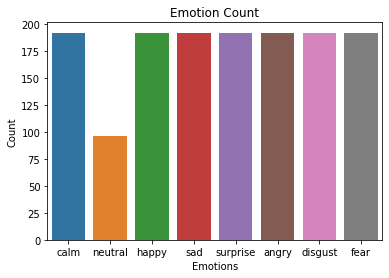

In [ ]:
sns.countplot(RAV_df['emotion'])
plt.title('Emotion Count')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show();

In [ ]:
def waveplot(data, sr, emotion):
  plt.figure(figsize=(10,4))
  plt.title(emotion, size=20)
  librosa.display.waveplot(data, sr=sr)
  plt.show()

def spectogram(data, sr, emotion):
  x = librosa.stft(data)
  xdb = librosa.amplitude_to_db(abs(x))
  plt.figure(figsize=(10,4))
  plt.title(emotion, size=20)
  librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()

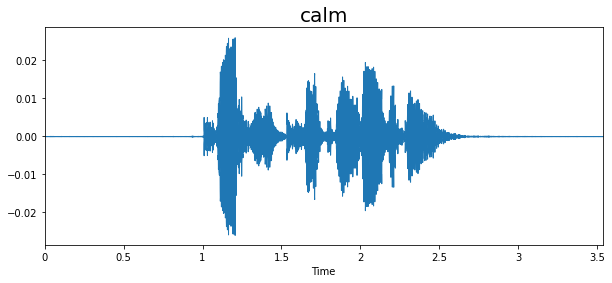

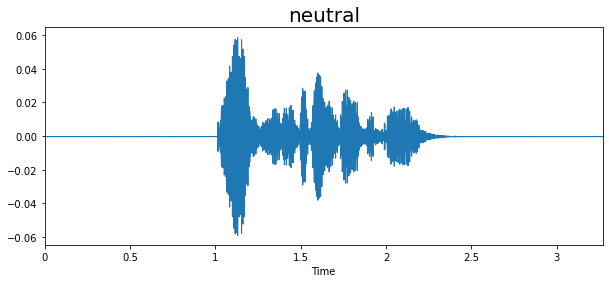

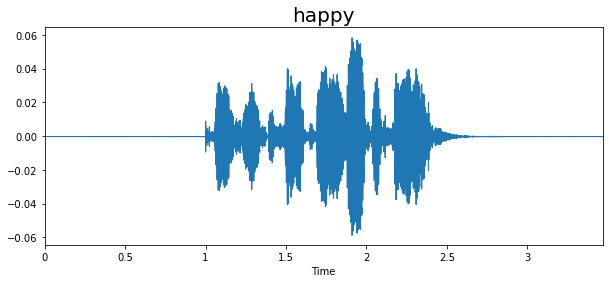

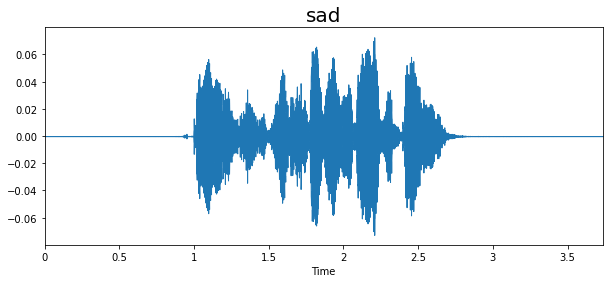

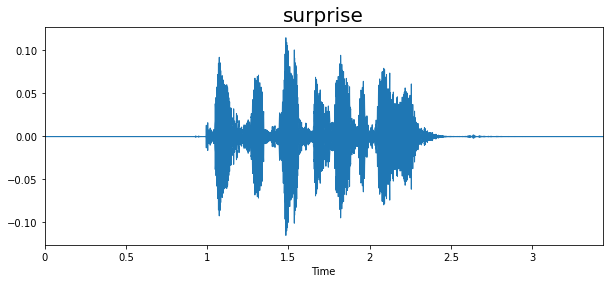

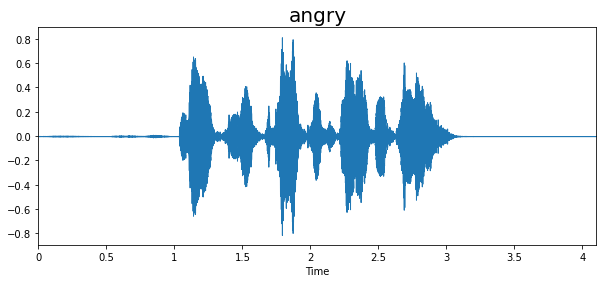

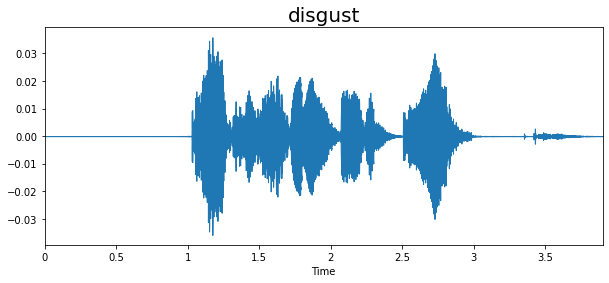

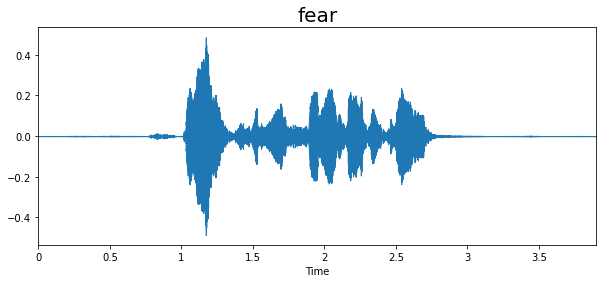

In [ ]:
unique_emotions = RAV_df['emotion'].unique()

for i in range(len(unique_emotions)):
  e = unique_emotions[i]
  p = list(RAV_df['path'][RAV_df['emotion']==e])[0]
  data, sampling_rate = librosa.load(p)
  waveplot(data, sampling_rate, e)

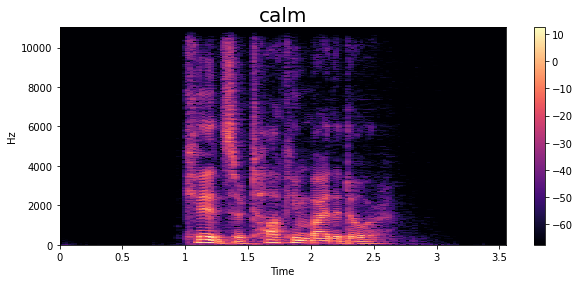

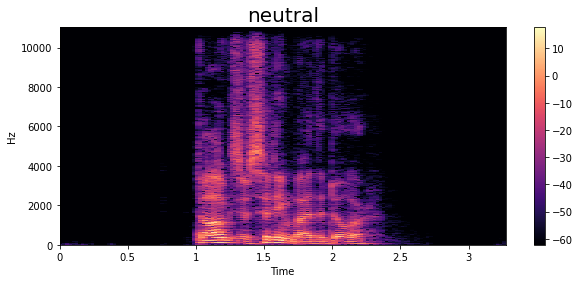

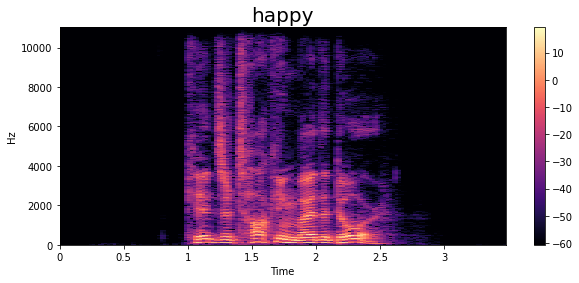

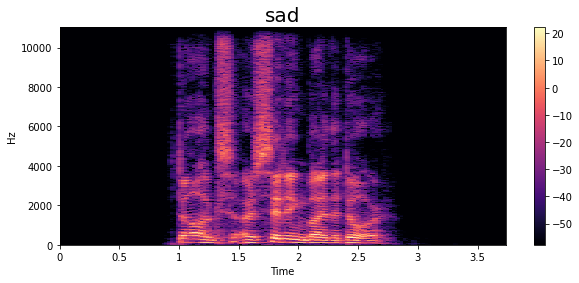

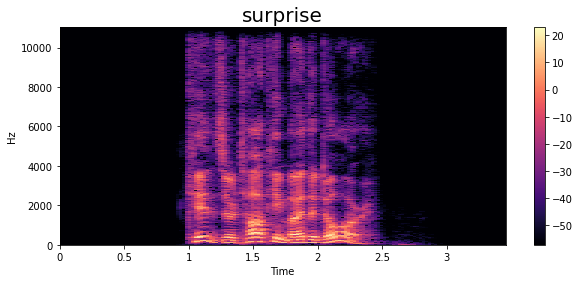

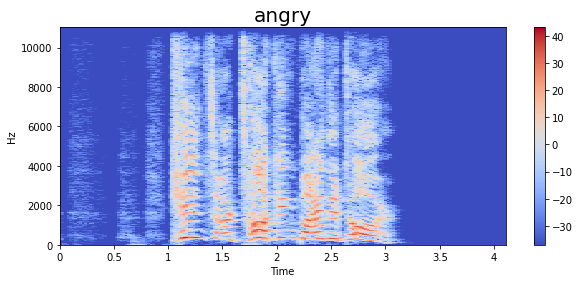

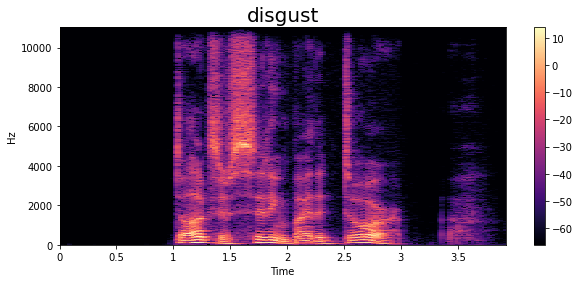

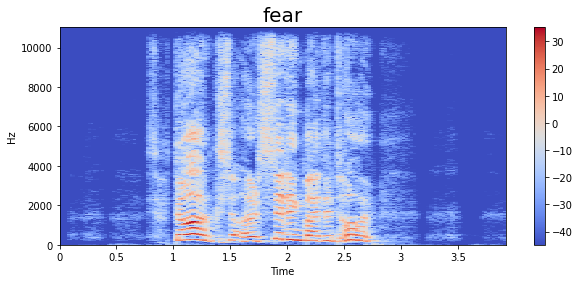

In [ ]:
unique_emotions = RAV_df['emotion'].unique()

for i in range(len(unique_emotions)):
  e = unique_emotions[i]
  p = list(RAV_df['path'][RAV_df['emotion']==e])[0]
  data, sampling_rate = librosa.load(p)
  spectogram(data, sampling_rate, e)

### Feature Extraction

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    if chroma:
      stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc:
      mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
      result=np.hstack((result, mfccs))
    if chroma:
      chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
      result=np.hstack((result, chroma))
    if mel:
      mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
      result=np.hstack((result, mel))
  return result

In [ ]:
features = []

for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
      features.append(extract_feature((RAV + i + '/' + f), mfcc = True, chroma = True, mel = True))

In [ ]:
RAV_df = pd.concat([RAV_df, pd.DataFrame(features)], axis=1)
RAV_df

,path,gender,emotion,labels,0,1,2,3,4,5,...,170,171,172,173,174,175,176,177,178,179
0,/content/drive/MyDrive/Colab Notebooks/DATASET...,male,calm,male_calm,-759.917847,75.788948,6.028998,14.562723,6.459432,14.636641,...,1.376438e-07,1.088035e-07,9.219798e-08,5.054346e-08,3.130356e-08,1.891648e-08,1.093055e-08,6.907234e-09,5.929377e-09,5.490418e-09
1,/content/drive/MyDrive/Colab Notebooks/DATASET...,male,neutral,male_neutral,-714.994934,69.690376,3.925558,11.925324,6.423344,11.014112,...,6.041488e-07,4.855367e-07,4.119043e-07,2.542117e-07,2.857562e-07,3.092161e-07,3.254369e-07,1.852872e-07,2.746995e-08,5.541867e-09
2,/content/drive/MyDrive/Colab Notebooks/DATASET...,male,neutral,male_neutral,-726.217224,68.541420,3.293398,12.205300,5.510278,13.667410,...,3.798515e-07,2.659118e-07,1.358990e-07,6.421450e-08,4.124923e-08,2.838078e-08,2.313626e-08,1.160476e-08,5.817900e-09,5.362134e-09
3,/content/drive/MyDrive/Colab Notebooks/DATASET...,male,neutral,male_neutral,-710.959839,67.579185,5.783356,13.227695,6.194669,12.640195,...,1.410576e-06,1.025075e-06,9.816289e-07,1.029304e-06,5.594787e-07,2.913279e-07,1.172367e-07,4.114702e-08,7.315270e-09,5.706893e-09
4,/content/drive/MyDrive/Colab Notebooks/DATASET...,male,calm,male_calm,-735.006592,79.093056,8.141059,11.413560,5.174132,15.393293,...,7.811629e-08,4.128243e-08,3.126313e-08,2.750857e-08,1.755317e-08,9.856551e-09,8.679062e-09,7.096063e-09,5.672045e-09,5.365027e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,/content/drive/MyDrive/Colab Notebooks/DATASET...,female,surprise,female_surprise,-698.756165,43.077576,-5.472865,7.982753,-7.701614,1.119739,...,5.131647e-06,3.698133e-06,2.041553e-06,1.749528e-06,1.470094e-06,6.518017e-07,3.525474e-07,1.503467e-07,1.512397e-08,5.859980e-09
1436,/content/drive/MyDrive/Colab Notebooks/DATASET...,female,surprise,female_surprise,-536.693726,43.281143,-9.283842,9.252940,-10.546877,3.863054,...,3.018395e-04,1.848297e-04,1.166171e-04,8.184707e-05,5.650412e-05,3.449367e-05,3.002333e-05,1.232831e-05,1.065019e-06,1.146904e-08
1437,/content/drive/MyDrive/Colab Notebooks/DATASET...,female,angry,female_angry,-560.528503,52.595726,-14.047179,3.461836,-3.746298,-1.910375,...,3.852172e-05,3.154696e-05,2.185751e-05,1.392635e-05,1.438286e-05,9.206890e-06,4.431349e-06,2.660923e-06,2.535511e-07,8.347889e-09
1438,/content/drive/MyDrive/Colab Notebooks/DATASET...,female,disgust,female_disgust,-621.325439,68.572586,-22.172903,6.308883,-2.009742,-6.674680,...,5.792499e-06,3.951911e-06,2.623556e-06,1.436639e-06,1.183562e-06,8.157942e-07,3.891013e-07,1.776508e-07,3.075376e-08,9.189105e-09


In [ ]:
RAV_df.isnull().values.any()

False

In [ ]:
le = LabelEncoder()

RAV_df['emotion']= le.fit_transform(RAV_df['emotion'])

In [ ]:
X = RAV_df.drop(['path', 'gender', 'emotion', 'labels'], axis = 1)
y = RAV_df['emotion']

In [ ]:
X = np.expand_dims(X, -1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape)

(921, 180, 1) (921,) (231, 180, 1) (231,) (288, 180, 1) (288,)


### Creating LSTM Model

In [ ]:
model = Sequential([
    LSTM(900, return_sequences=True, input_shape=(X_train.shape[1],1)),
    LSTM(750, return_sequences=True),
    Dropout(0.4),
    LSTM(690, return_sequences=True),
    Dropout(0.4),
    LSTM(600, return_sequences=False),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(8, activation='softmax')
])

In [ ]:

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180, 900)          3247200   
                                                                 
 lstm_1 (LSTM)               (None, 180, 750)          4953000   
                                                                 
 dropout (Dropout)           (None, 180, 750)          0         
                                                                 
 lstm_2 (LSTM)               (None, 180, 690)          3977160   
                                                                 
 dropout_1 (Dropout)         (None, 180, 690)          0         
                                                                 
 lstm_3 (LSTM)               (None, 600)               3098400   
                                                                 
 dense (Dense)               (None, 512)               3

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(filepath='rnn.h5', verbose=2, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid), epochs=100, batch_size=64, shuffle=True , verbose=2, callbacks=[checkpoint,earlystopping])

Epoch 1/100

Epoch 1: val_loss improved from inf to 2.07561, saving model to rnn.h5
15/15 - 32s - loss: 2.0899 - accuracy: 0.1205 - val_loss: 2.0756 - val_accuracy: 0.1082 - 32s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_loss improved from 2.07561 to 2.06245, saving model to rnn.h5
15/15 - 18s - loss: 2.0685 - accuracy: 0.1412 - val_loss: 2.0624 - val_accuracy: 0.1212 - 18s/epoch - 1s/step
Epoch 3/100

Epoch 3: val_loss improved from 2.06245 to 2.05805, saving model to rnn.h5
15/15 - 18s - loss: 2.0708 - accuracy: 0.1260 - val_loss: 2.0581 - val_accuracy: 0.1472 - 18s/epoch - 1s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 2.05805
15/15 - 18s - loss: 2.0608 - accuracy: 0.1336 - val_loss: 2.0584 - val_accuracy: 0.1602 - 18s/epoch - 1s/step
Epoch 5/100

Epoch 5: val_loss did not improve from 2.05805
15/15 - 18s - loss: 2.0725 - accuracy: 0.1379 - val_loss: 2.0641 - val_accuracy: 0.1602 - 18s/epoch - 1s/step
Epoch 6/100

Epoch 6: val_loss did not improve from 2.05805
15/15 - 18

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.1423611044883728
